In [1]:
from __future__ import annotations

import importlib
import os

import hist
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import xgboost as xgb
import awkward as ak

import HH4b
from HH4b import postprocessing, hh_vars
from HH4b.postprocessing import corrections
from HH4b.postprocessing.PostProcess import add_bdt_scores, get_jets_for_txbb_sf
from HH4b.hh_vars import (
    ttbarsfs_decorr_ggfbdt_bins,
    ttbarsfs_decorr_txbb_bins,
    ttbarsfs_decorr_vbfbdt_bins,
    txbbsfs_decorr_pt_bins,
    txbbsfs_decorr_txbb_wps,
    mreg_strings,
    txbb_strings
)


plt.style.use(hep.style.ROOT)
import json

package_path = os.path.dirname(HH4b.__file__)

In [2]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

In [3]:
txbb_version = "glopart-v2"
bdt_model_name = "25Feb5_v13_glopartv2_rawmass"
bdt_config = "v13_glopartv2"
bin1_txbb = 0.945
bin1_bdt = 0.94
bin2_txbb = 0.85
bin2_bdt = 0.755
vbf_txbb = 0.8
vbf_bdt = 0.9825
presel_txbb = 0.3
data_dir = "25May9_v12v2_private_signal"
input_dir = f"/ceph/cms/store/user/dprimosc/bbbb/skimmer/{data_dir}"

bdt_axis = hist.axis.Variable(list(np.arange(0.9, 1, 0.001)), name="BDT score")
txbb1_axis = hist.axis.Variable(list(np.arange(0.9, 1, 0.001)), name=r"Jet 1 $T_{Xbb}$")
txbb2_axis = hist.axis.Variable(list(np.arange(0, 1, 0.001)), name=r"Jet 2 $T_{Xbb}$")
    
TXbb_pt_corr_bins = txbbsfs_decorr_pt_bins[txbb_version]
TXbb_wps = txbbsfs_decorr_txbb_wps[txbb_version]
trigger_region = "QCD"

In [32]:
def calculate_trigger_weights(
    events_dict: pd.DataFrame,
    key: str,
    year: str,
    txbb: str,
    trigger_region: str,
    n_events: int,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    # calculates triggerWeight
    trigger_weight = np.ones(n_events)
    trigger_weight_up = np.ones(n_events)
    trigger_weight_dn = np.ones(n_events)
    if key != "data":
        trigger_weight, _, total, total_err = corrections.trigger_SF(
            year, events_dict, txbb_strings[txbb], trigger_region
        )
        trigger_weight_up = trigger_weight * (1 + total_err / total)
        trigger_weight_dn = trigger_weight * (1 - total_err / total)

    return trigger_weight, trigger_weight_up, trigger_weight_dn


def calculate_txbb_weights(
    bdt_events: pd.DataFrame,
    key: str,
    txbb_sf: dict,
    TXbb_wps,  # TODO: fill in datatype (dict?)
    TXbb_pt_corr_bins,  # TODO: fill in datatype (dict?)
    n_events: int,
):
    txbb_sf_weight = np.ones(n_events)
    all_txbb_bins = ak.Array([TXbb_wps[wp] for wp in TXbb_wps])
    all_pt_bins = ak.Array([TXbb_pt_corr_bins[wp] for wp in TXbb_pt_corr_bins])
    txbb_range = [ak.min(all_txbb_bins), ak.max(all_txbb_bins)]
    pt_range = [ak.min(all_pt_bins), ak.max(all_pt_bins)]
    for ijet in get_jets_for_txbb_sf(key):
        txbb_sf_weight *= corrections.restrict_SF(
            txbb_sf["nominal"],
            bdt_events[f"H{ijet}TXbb"].to_numpy(),
            bdt_events[f"H{ijet}Pt"].to_numpy(),
            txbb_range,
            pt_range,
        )
    return txbb_sf_weight

def get_dataframe(events_dict, year, bdt_model_name, bdt_config):
    bdt_model = xgb.XGBClassifier()
    bdt_model.load_model(
        fname=f"{package_path}/boosted/bdt_trainings_run3/{bdt_model_name}/trained_bdt.model"
    )
    make_bdt_dataframe = importlib.import_module(
        f".{bdt_config}", package="HH4b.boosted.bdt_trainings_run3"
    )

    bdt_events_dict = {}
    for key in events_dict:
        events = events_dict[key]
        bdt_events = make_bdt_dataframe.bdt_dataframe(events)
        preds = bdt_model.predict_proba(bdt_events)
        # inference
        add_bdt_scores(bdt_events, preds)

        # extra variables
        bdt_events["H1PNetMass"] = events[mreg_strings[txbb_version]][0]
        bdt_events["H2PNetMass"] = events[mreg_strings[txbb_version]][1]
        bdt_events["H1Msd"] = events["bbFatJetMsd"][0]
        bdt_events["H1TXbb"] = events[txbb_strings[txbb_version]][0]
        bdt_events["H2TXbb"] = events[txbb_strings[txbb_version]][1]
        bdt_events["finalWeight"] = events["finalWeight"].to_numpy()
        for i in range(6):
            bdt_events[f"scale_weights_{i}"] = events["scale_weights"][i]

        
        # triggerWeights
        nevents = len(bdt_events["H1Pt"])
        trigger_weight, trigger_weight_up, trigger_weight_dn = calculate_trigger_weights(
            events, key, year, txbb_version, trigger_region, nevents
        )
        
        # TXbbWeight
        txbb_sf_weight = calculate_txbb_weights(
            bdt_events, key, txbb_sf, TXbb_wps, TXbb_pt_corr_bins, nevents
        )
    
        bdt_events["weight"] = events["finalWeight"].to_numpy() * trigger_weight # * txbb_sf_weight

        print(postprocessing.HLTs[year])
        bdt_events["hlt"] = np.any(
            np.array(
                [events[trigger][0] for trigger in postprocessing.HLTs[year] if trigger in events]
            ),
            axis=0,
        )
        mask_hlt = bdt_events["hlt"] == 1

        # masks
        mask_presel = (
            (bdt_events["H1Msd"] > 40)
            & (bdt_events["H1Pt"] > 300)
            & (bdt_events["H2Pt"] > 250)
            & (bdt_events["H1TXbb"] > presel_txbb)
        )
        mask_mass = (
            (bdt_events["H1PNetMass"] > 60)
            & (bdt_events["H1PNetMass"] < 220)
            & (bdt_events["H2PNetMass"] > 60)
            & (bdt_events["H2PNetMass"] < 220)
        )
        bdt_events = bdt_events[(mask_mass) & (mask_presel)]
        

        columns = [
            "bdt_score",
            "bdt_score_vbf",
            "H1TXbb",
            "H2TXbb",
            "H1Msd",
            "H1PNetMass",
            "H2PNetMass",
            "H1Pt",
            "H2Pt",
            "weight",
            "H1Pt",
            "H2Pt",
            "VBFjjMass",
            "VBFjjDeltaEta",
            "hlt",
            "finalWeight",
        ]
        for i in range(6):
            columns.append(f"scale_weights_{i}")
        bdt_events_dict[key] = bdt_events[columns]
    return bdt_events_dict

In [33]:
DATA_SAMPLES = ["JetMET", "Muon", "EGamma"]

samples_run3 = {
    "2022EE": {
        "hh4b": ["GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV?"],
        # "vbfhh4b": ["VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8"],
        # "vbfhh4b-k2v0": ["VBFHHto4B_CV_1_C2V_0_C3_1_TuneCP5_13p6TeV_madgraph-pythia8"],
        # "data": [f"{key}_Run" for key in DATA_SAMPLES],
    },
    "2022": {
        "hh4b": ["GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV?"],
        # "vbfhh4b": ["VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8"],
        # "vbfhh4b-k2v0": ["VBFHHto4B_CV_1_C2V_0_C3_1_TuneCP5_13p6TeV_madgraph-pythia8"],
        # "data": [f"{key}_Run" for key in DATA_SAMPLES],
    },
    "2023": {
        "hh4b": ["GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV?"],
        # "vbfhh4b": ["VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8"],
        # "vbfhh4b-k2v0": ["VBFHHto4B_CV_1_C2V_0_C3_1_TuneCP5_13p6TeV_madgraph-pythia8"],
        # "data": [f"{key}_Run" for key in DATA_SAMPLES],
    },
    "2023BPix": {
        "hh4b": ["GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV?"],
        # "vbfhh4b": ["VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8"],
        # "vbfhh4b-k2v0": ["VBFHHto4B_CV_1_C2V_0_C3_1_TuneCP5_13p6TeV_madgraph-pythia8"],
        # "data": [f"{key}_Run" for key in DATA_SAMPLES],
    },
}

bdt_events_dict_year = {}
for year in samples_run3:
    txbb_sf = corrections._load_txbb_sfs(
        year,
        "sf_glopart-v2_zbb",
        TXbb_wps,
        TXbb_pt_corr_bins,
        txbb_version,
    )
    events = HH4b.postprocessing.load_run3_samples(
        input_dir=input_dir,
        year=year,
        txbb_version=txbb_version,
        samples_run3=samples_run3,
        reorder_txbb=True,
        scale_and_smear=False,
        load_systematics=True,
        mass_str=mreg_strings[txbb_version],
        bdt_version=bdt_model_name,
    )
    bdt_events_dict_year[year] = get_dataframe(events, year, bdt_model_name, bdt_config)

[2025-08-04 15:12:49,697] INFO: HH4b.utils           Loaded GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV: 259322 entries


['AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35', 'AK8PFJet425_SoftDropMass40']


[2025-08-04 15:12:51,813] INFO: HH4b.utils           Loaded GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV: 84290 entries


['AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35', 'AK8PFJet425_SoftDropMass40']


[2025-08-04 15:12:53,792] INFO: HH4b.utils           Loaded GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV: 253469 entries


['AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35', 'AK8PFJet230_SoftDropMass40_PNetBB0p06', 'AK8PFJet400_SoftDropMass40', 'AK8PFJet425_SoftDropMass40']


[2025-08-04 15:12:55,904] INFO: HH4b.utils           Loaded GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV: 127167 entries


['AK8PFJet230_SoftDropMass40_PNetBB0p06', 'AK8PFJet400_SoftDropMass40', 'AK8PFJet425_SoftDropMass40']


In [34]:
events_combined, scaled_by = postprocessing.combine_run3_samples(
    bdt_events_dict_year,
    ["hh4b"], # , "vbfhh4b", "vbfhh4b-k2v0", "data"],
    bg_keys=["ttbar"],
    scale_processes={},
    years_run3=bdt_events_dict_year.keys(),
)

All years dict_keys(['2022EE', '2022', '2023', '2023BPix']): 62428.6


Index(['bdt_score', 'bdt_score_vbf', 'H1TXbb', 'H2TXbb', 'H1Msd', 'H1PNetMass',
       'H2PNetMass', 'H1Pt', 'H2Pt', 'weight', 'H1Pt', 'H2Pt', 'VBFjjMass',
       'VBFjjDeltaEta', 'hlt', 'finalWeight', 'scale_weights_0',
       'scale_weights_1', 'scale_weights_2', 'scale_weights_3',
       'scale_weights_4', 'scale_weights_5'],
      dtype='object')


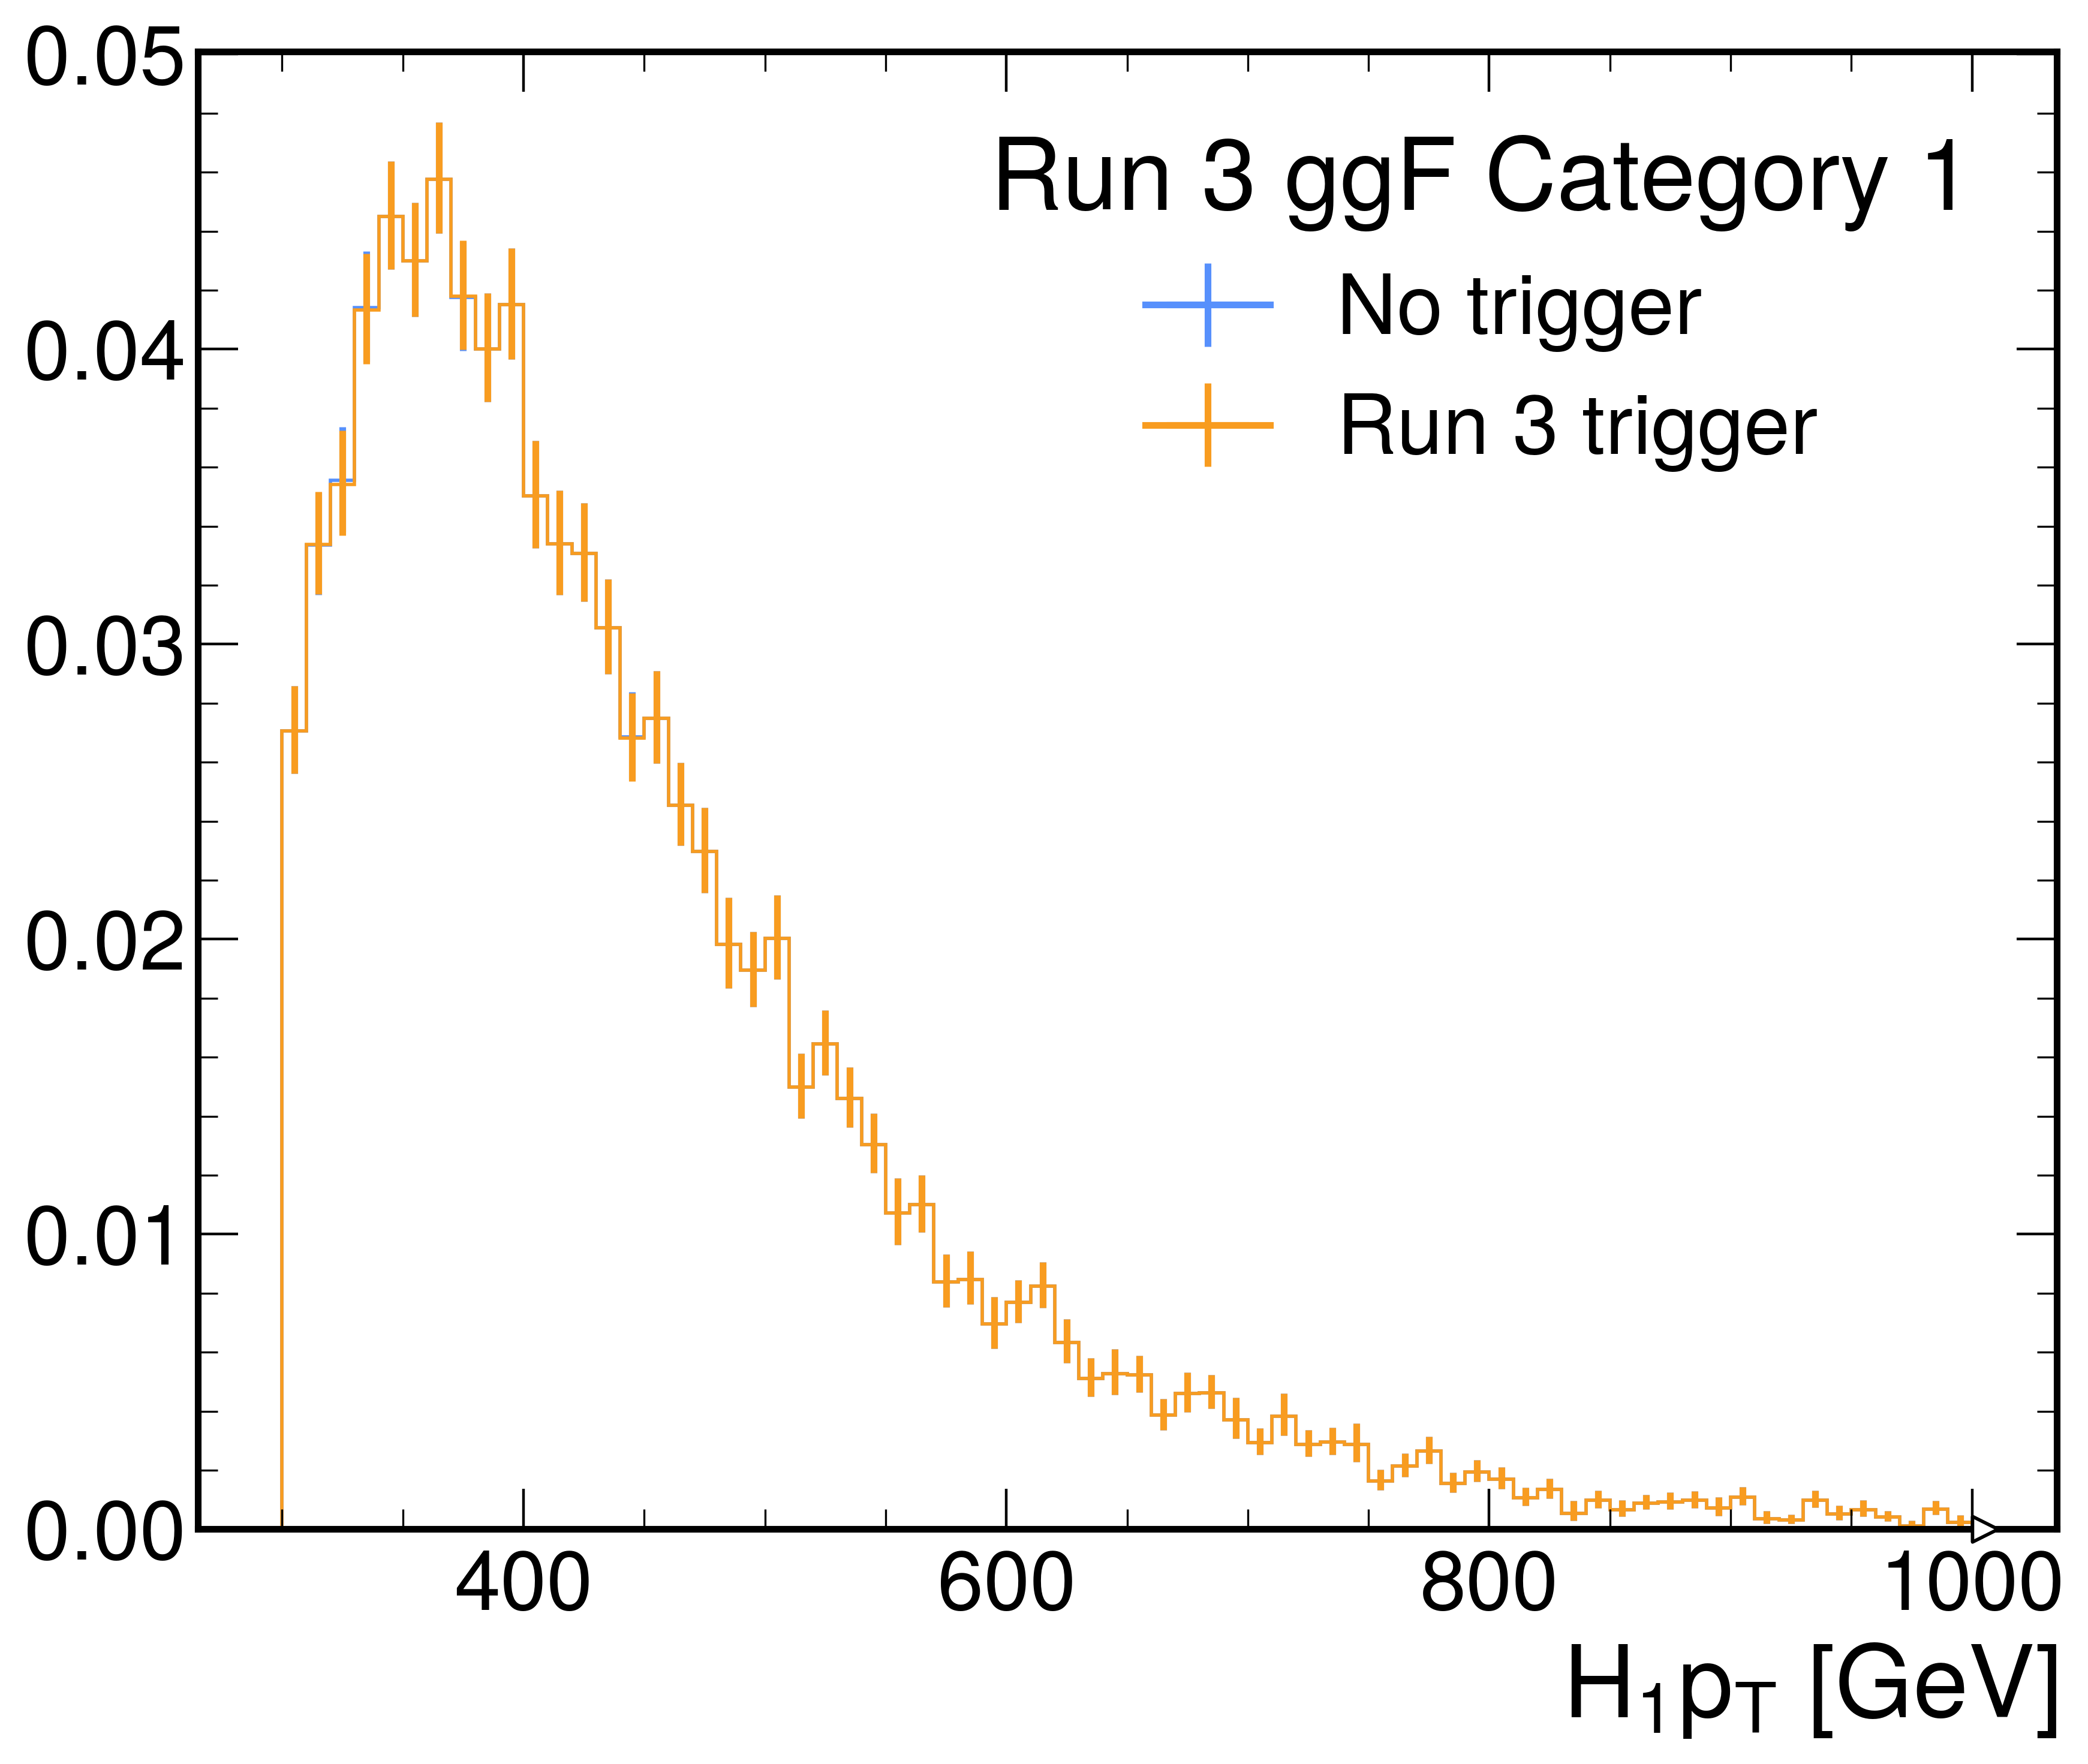

In [42]:
pt1_hist = {}
pt2_hist = {}
pt1_bin1_hist = {}
pt2_bin1_hist = {}
pt1_axis = hist.axis.Regular(70, 300, 1000, name="H1Pt", label="$H_{1} p_{T}$ [GeV]")
pt2_axis = hist.axis.Regular(75, 250, 1000, name="H2Pt", label="$H_{2} p_{T}$ [GeV]")


for key in events_combined:
    events = events_combined[key]
    print(events.keys())
    pt1 = events["H1Pt"].to_numpy()[:, 0]
    pt2 = events["H2Pt"].to_numpy()[:, 0]
    weight = events["weight"].to_numpy()
    pt1_hist[key] = hist.Hist(pt1_axis, storage=hist.storage.Weight())
    pt2_hist[key] = hist.Hist(pt2_axis, storage=hist.storage.Weight())
    pt1_bin1_hist[key] = hist.Hist(pt1_axis, storage=hist.storage.Weight())
    pt2_bin1_hist[key] = hist.Hist(pt2_axis, storage=hist.storage.Weight())
    mask_bin1 = (events["H2TXbb"] > bin1_txbb) & (events["bdt_score"] > bin1_bdt)
    mask_hlt = events["hlt"].to_numpy() == 1
    pt1_hist[key].fill(pt1[mask_bin1], weight=weight[mask_bin1])
    pt2_hist[key].fill(pt2[mask_bin1], weight=weight[mask_bin1])
    pt1_bin1_hist[key].fill(pt1[mask_hlt & mask_bin1], weight=weight[mask_hlt & mask_bin1])
    pt2_bin1_hist[key].fill(pt2[mask_hlt & mask_bin1], weight=weight[mask_hlt & mask_bin1])


fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#main_ax_artists, sublot_ax_arists = pt1_bin1_hist["hh4b"].plot_ratio(
#    pt1_hist["hh4b"],
#    rp_ylabel=r"Efficiency",
#    rp_num_label="ggF Category 1",
#    rp_denom_label="Preselection",
#    rp_uncert_draw_type="line",  # line or bar
#    rp_uncertainty_type="efficiency",
#)
pt1_hist["hh4b"].project("H1Pt").plot(ax=ax, label="No trigger")
pt1_bin1_hist["hh4b"].project("H1Pt").plot(ax=ax, label="Run 3 trigger")
plt.legend(title="Run 3 ggF Category 1")
plt.show()

In [47]:
import uproot
with uproot.open("JetHTTriggerEfficiency_2016.root") as f:
    print(f.keys())

['efficiency_pt;3', 'efficiency_mass;3', 'efficiency_PNetXbb;3', 'efficiency_ptmass;3', 'efficiency_ptmass_Xbb0p0To0p9;3', 'efficiency_ptmass_Xbb0p9To0p95;3', 'efficiency_ptmass_Xbb0p95To0p98;3', 'efficiency_ptmass_Xbb0p98To1p0;3', 'efficiency_Pt_massBin6_Xbb0p0To0p9;3', 'efficiency_Pt_massBin7_Xbb0p0To0p9;3', 'efficiency_Pt_massBin8_Xbb0p0To0p9;3', 'efficiency_Pt_massBin6_Xbb0p9To0p95;3', 'efficiency_Pt_massBin7_Xbb0p9To0p95;3', 'efficiency_Pt_massBin8_Xbb0p9To0p95;3', 'efficiency_Pt_massBin6_Xbb0p95To0p98;3', 'efficiency_Pt_massBin7_Xbb0p95To0p98;3', 'efficiency_Pt_massBin8_Xbb0p95To0p98;3', 'efficiency_Pt_massBin6_Xbb0p98To1p0;3', 'efficiency_Pt_massBin7_Xbb0p98To1p0;3', 'efficiency_Pt_massBin8_Xbb0p98To1p0;3']


KeyError: 'vbfhh4b-k2v0'

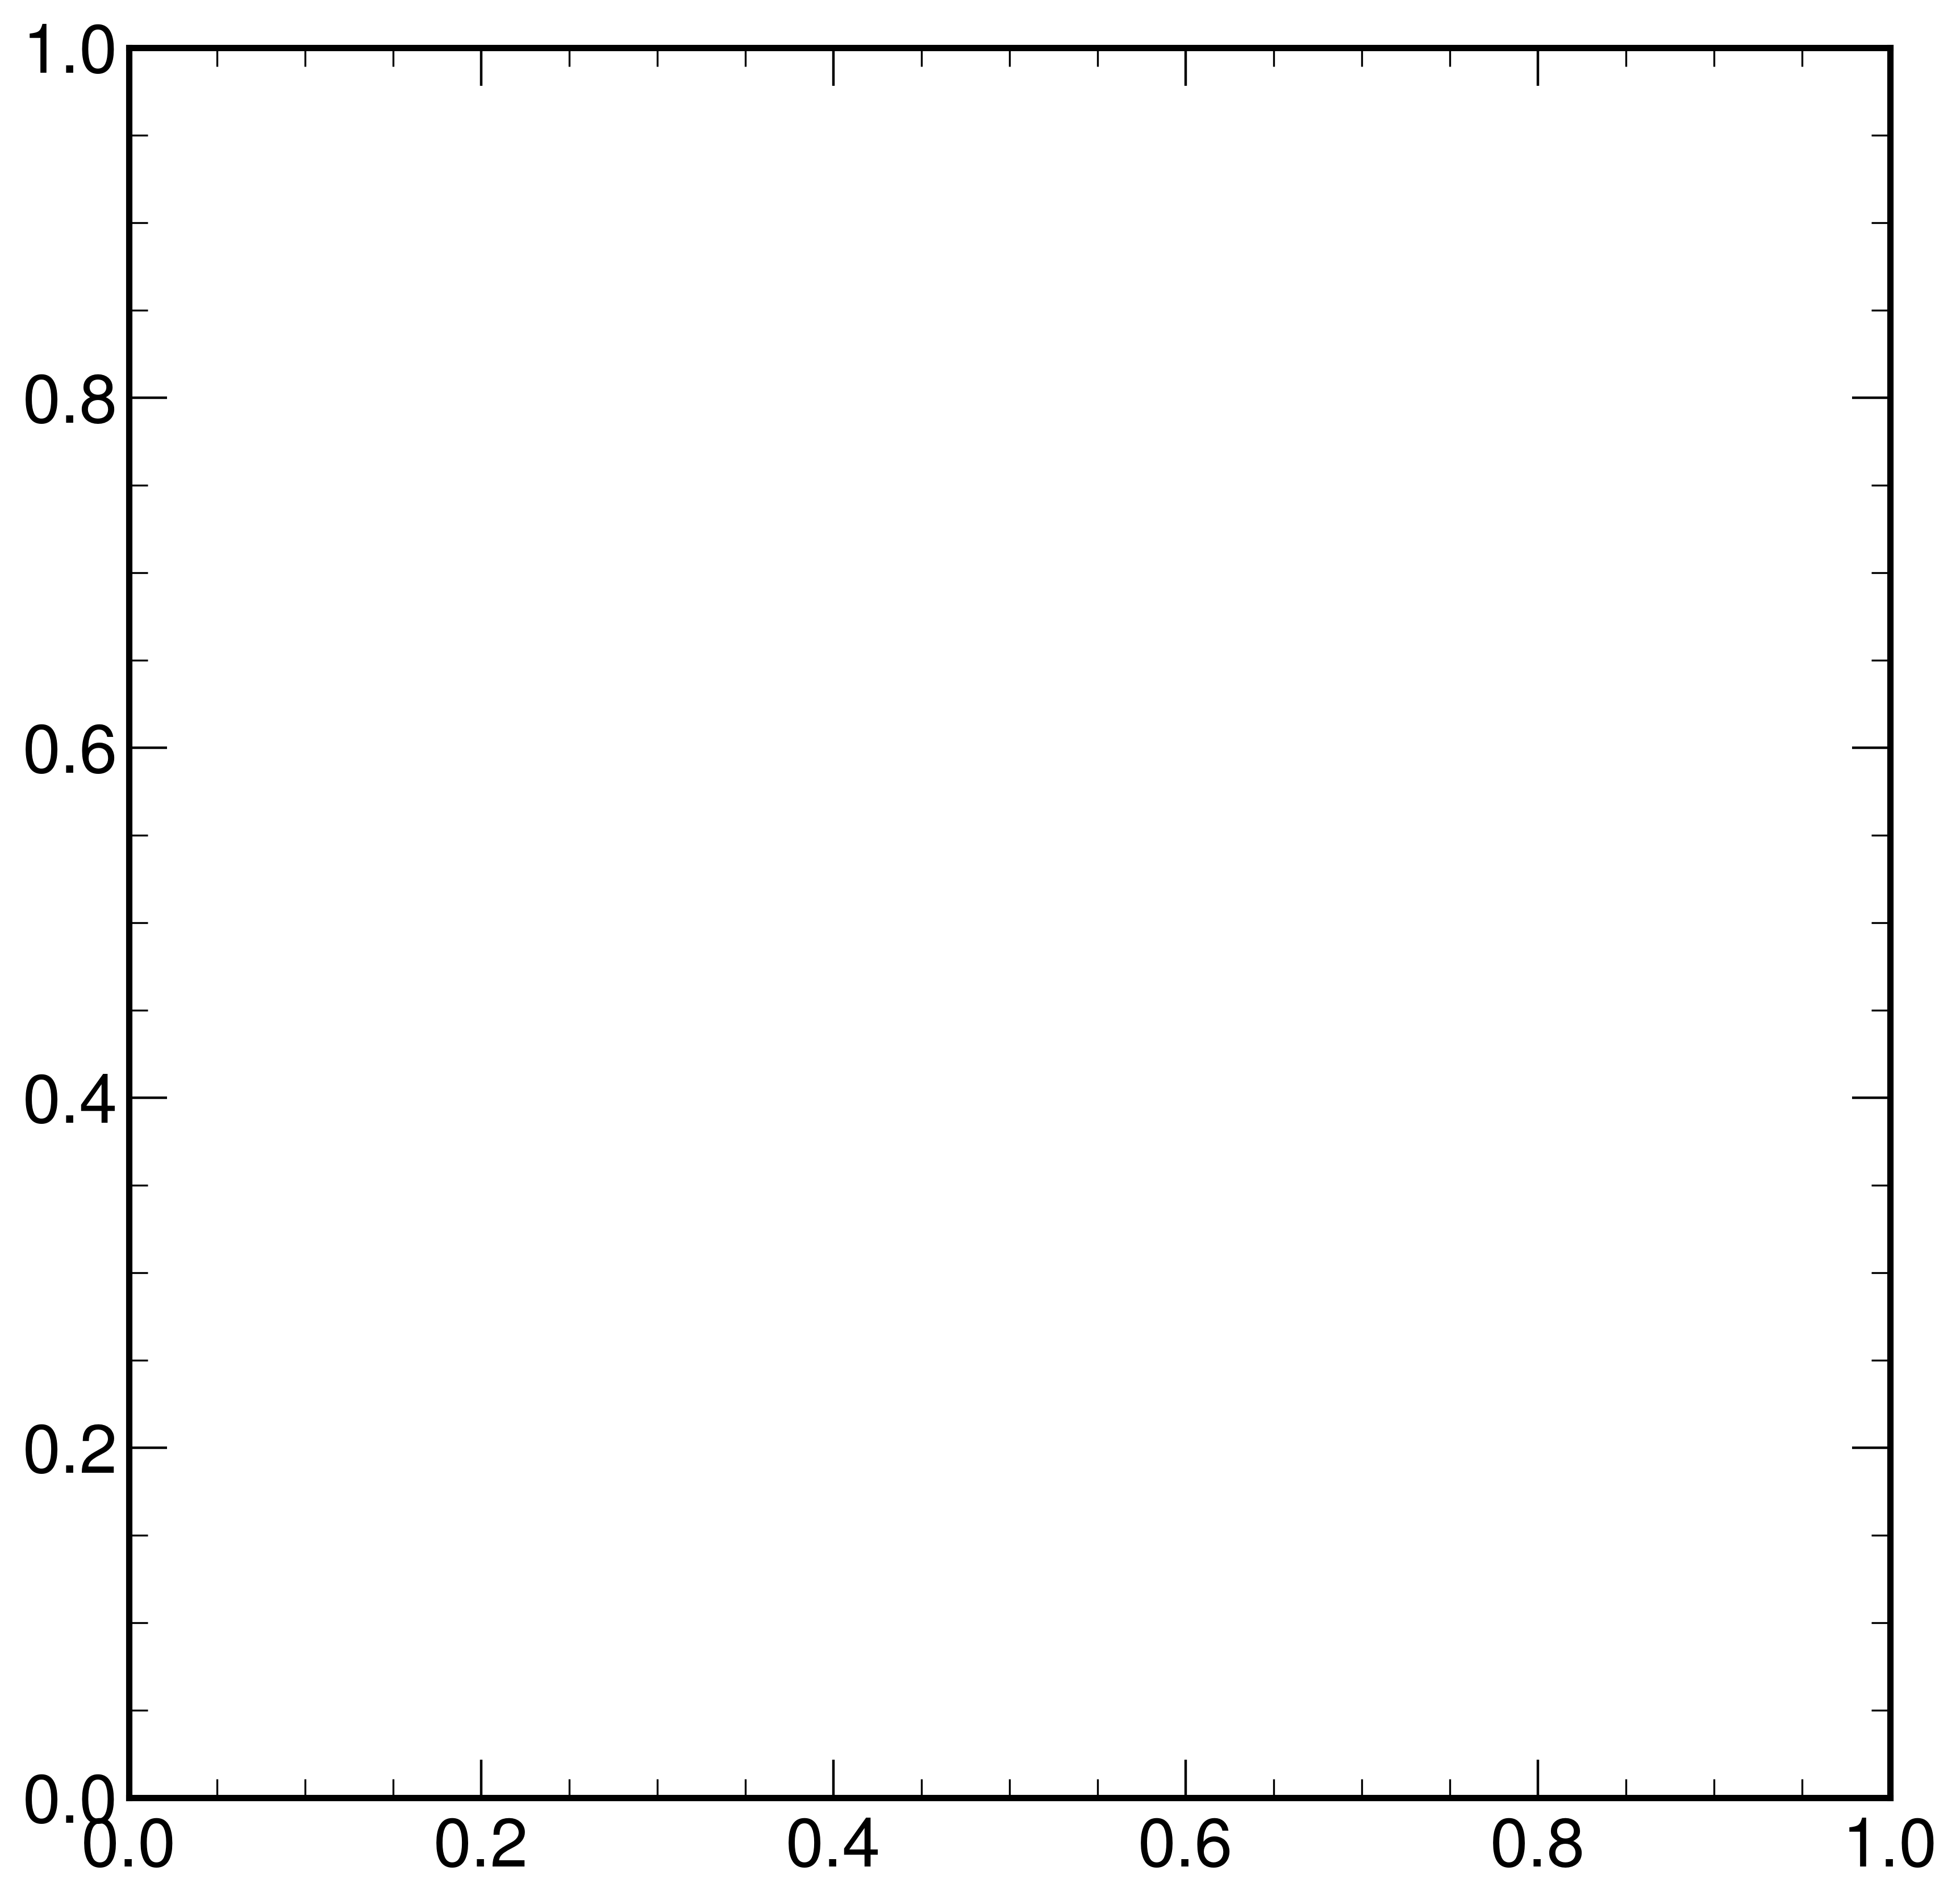

In [10]:
vbfjjmass_axis = hist.axis.Variable(
    list(np.arange(0, 5100, 100)), name="VBFjjMass", label="VBF dijet mass [GeV]"
)
vbfjjmass_hist = {}
for key in events_combined:
    events = events_combined[key]
    mask_bin1 = (events["H2TXbb"] > bin1_txbb) & (events["bdt_score"] > bin1_bdt)
    mask_vbf = (~mask_bin1) & (events["H2TXbb"] > vbf_txbb) & (events["bdt_score_vbf"] > vbf_bdt)
    vbfjjmass_hist[key] = hist.Hist(vbfjjmass_axis, storage=hist.storage.Weight())
    vbfjjmass_hist[key].fill(events["VBFjjMass"], weight=events["weight"])

fig, ax = plt.subplots()
hep.histplot(
    vbfjjmass_hist["vbfhh4b-k2v0"], label=r"VBF HH4b $\kappa_{2V}=0$", ax=ax, histtype="fill"
)
ax.set_ylabel("Events")
ax.set_xlim(0, 5000)
ax.legend()

np.sum(vbfjjmass_hist["vbfhh4b-k2v0"].values()[0:3]) / np.sum(
    vbfjjmass_hist["vbfhh4b-k2v0"].values()
)

In [ ]:
events = events_combined["vbfhh4b-k2v0"]
bdt_axis = hist.axis.Variable(list(np.arange(0, 1.02, 0.02)), name="bdt_score_vbf")
bdt_hist = hist.Hist(bdt_axis, storage=hist.storage.Weight())

bdt_hist.fill(bdt_score_vbf=events["bdt_score_vbf"], weight=events["weight"])
bdt_scale_hists = hist.Hist(
    hist.axis.StrCategory([f"scale_weights_{i}" for i in range(6)], name="Sample"),
    bdt_axis,
    storage=hist.storage.Weight(),
)

for i in range(6):
    bdt_scale_hists.fill(
        Sample=f"scale_weights_{i}",
        bdt_score_vbf=events["bdt_score_vbf"],
        weight=events[f"scale_weights_{i}"],
    )


fig, (ax, rax) = plt.subplots(
    2, 1, figsize=(12, 14), gridspec_kw={"height_ratios": [3, 1], "hspace": 0}, sharex=True
)

shape_up = np.max(bdt_scale_hists.values(), axis=0)
shape_down = np.min(bdt_scale_hists.values(), axis=0)
yerr_up = shape_up - bdt_hist.values()
yerr_down = bdt_hist.values() - shape_down
yerr = np.concatenate([yerr_down[None, :], yerr_up[None, :]], axis=0)

nom = bdt_hist.values()
hep.histplot(bdt_hist, ax=ax, histtype="step", label=r"VBF HH $\kappa_{2V}=0$", yerr=0)
hep.histplot(bdt_hist, ax=ax, histtype="band", yerr=yerr, label="QCD scale uncertainty")
ax.legend()
ax.semilogy()
ax.set_ylim([0.1, 100])
ax.set_ylabel("Events")

hep.histplot(bdt_hist / nom, ax=rax, histtype="step", yerr=0)
hep.histplot(bdt_hist / nom, ax=rax, yerr=yerr / nom, histtype="band")

rax.set_ylim([0.87, 1.13])
rax.set_xlim([0, 1])
rax.legend()
rax.set_xlabel(r"$BDT_{VBF}$")
rax.set_ylabel("Ratio")
rax.grid(axis="y")

In [11]:
labels = {
    "hh4b": "HH(4b)",
}

from HH4b.hh_vars import txbbsfs_decorr_pt_bins, txbbsfs_decorr_txbb_wps
from HH4b.postprocessing import corrections

txbb_sf = {}
txbb_sf_weight = {}
mask_bin1 = {}
mask_vbf = {}
mask_bin2 = {}
mask_bin3 = {}
for year in samples_run3:
    events = bdt_events_dict_year[year]["hh4b"]
    nevents = len(events)
    mask_bin1[year] = (events["H2TXbb"] > bin1_txbb) & (events["bdt_score"] > bin1_bdt)
    mask_vbf[year] = (
        (~mask_bin1[year]) & (events["H2TXbb"] > vbf_txbb) & (events["bdt_score_vbf"] > vbf_bdt)
    )
    mask_bin2[year] = (
        (~mask_bin1[year])
        & (~mask_vbf[year])
        & (
            ((events["H2TXbb"] > bin1_txbb) & (events["bdt_score"] > bin2_bdt))
            | ((events["H2TXbb"] > bin2_txbb) & (events["bdt_score"] > bin1_bdt))
        )
    )
    mask_bin3[year] = (
        (~mask_bin1[year])
        & (~mask_vbf[year])
        & (~mask_bin2[year])
        & ((events["H2TXbb"] > bin2_txbb) & (events["bdt_score"] > bin2_bdt))
    )
    txbb_sf[year] = corrections._load_txbb_sfs(
        year,
        "sf_glopart-v2_freezeSFs_trial20241011",
        txbbsfs_decorr_txbb_wps[txbb_version],
        txbbsfs_decorr_pt_bins[txbb_version],
        txbb_version,
    )
    txbb_range = [0.8, 1]
    pt_range = [200, 1000]
    txbb_sf_weight[year] = np.ones(nevents)
    for ijet in [1, 2]:
        txbb_sf_weight[year] *= corrections.restrict_SF(
            txbb_sf[year]["nominal"],
            events[f"H{ijet}TXbb"].to_numpy(),
            events[f"H{ijet}Pt"].to_numpy(),
            txbb_range,
            pt_range,
        )

bins = np.arange(0.5, 2.0, 0.05)
data1 = np.concatenate([txbb_sf_weight[year][mask_bin1[year]] for year in txbb_sf_weight])
datavbf = np.concatenate([txbb_sf_weight[year][mask_vbf[year]] for year in txbb_sf_weight])
data2 = np.concatenate([txbb_sf_weight[year][mask_bin2[year]] for year in txbb_sf_weight])
data3 = np.concatenate([txbb_sf_weight[year][mask_bin3[year]] for year in txbb_sf_weight])

hist1 = np.histogram(data1, bins=bins)
histvbf = np.histogram(datavbf, bins=bins)
hist2 = np.histogram(data2, bins=bins)
hist3 = np.histogram(data3, bins=bins)

plt.figure()
hep.histplot(
    [hist1, histvbf, hist2, hist3],
    stack=True,
    histtype="fill",
    label=[
        f"ggF category 1, mean={np.mean(data1):.2f}",
        f"VBF category, mean={np.mean(datavbf):.2f}",
        f"ggF category 2, mean={np.mean(data2):.2f}",
        f"ggF category 3, mean={np.mean(data3):.2f}",
    ],
)
plt.xlabel("TXbb SF event weight")
plt.ylabel("Events")
plt.xlim(0.5, 2.5)
plt.legend(title="ggF HH(4b)")
plt.tight_layout()
plt.savefig("TXbb_SF_dist.pdf")
plt.show()

KeyError: 'WP4_pt250to450'

In [ ]:
labels = {
    "hh4b": "HH (4b)",
}


for key, events in events_combined.items():
    h_xbb1_bdt = hist.Hist(txbb1_axis, bdt_axis, storage=hist.storage.Weight())
    h_xbb1_bdt_bin1 = hist.Hist(txbb1_axis, bdt_axis, storage=hist.storage.Weight())
    h_xbb1_bdt_bin2 = hist.Hist(txbb1_axis, bdt_axis, storage=hist.storage.Weight())
    h_xbb1_bdt_bin3 = hist.Hist(txbb1_axis, bdt_axis, storage=hist.storage.Weight())

    h_xbb1 = hist.Hist(txbb1_axis, storage=hist.storage.Weight())
    h_xbb1_bin1 = hist.Hist(txbb1_axis, storage=hist.storage.Weight())
    h_xbb1_bin2 = hist.Hist(txbb1_axis, storage=hist.storage.Weight())
    h_xbb1_bin3 = hist.Hist(txbb1_axis, storage=hist.storage.Weight())

    mask_t2xbb = events["H2TXbb"] > bin1_txbb
    mask_bin1 = (events["H2TXbb"] > bin1_txbb) & (events["bdt_score"] > bin1_bdt)
    mask_bin2 = (~mask_bin1) & (
        ((events["H2TXbb"] > bin1_txbb) & (events["bdt_score"] > bin2_bdt))
        | ((events["H2TXbb"] > bin2_txbb) & (events["bdt_score"] > bin1_bdt))
    )
    mask_bin3 = (
        (~mask_bin1)
        & (~mask_bin2)
        & ((events["H2TXbb"] > bin2_txbb) & (events["bdt_score"] > bin2_bdt))
    )

    h_xbb1_bdt.fill(
        events["H1TXbb"],
        events["bdt_score"],
    )
    h_xbb1_bdt_bin1.fill(
        events["H1TXbb"][mask_bin1],
        events["bdt_score"][mask_bin1],
    )
    h_xbb1_bdt_bin2.fill(
        events["H1TXbb"][mask_bin2],
        events["bdt_score"][mask_bin2],
    )
    h_xbb1_bdt_bin3.fill(
        events["H1TXbb"][mask_bin3],
        events["bdt_score"][mask_bin3],
    )

    h_xbb1.fill(events["H1TXbb"])
    h_xbb1_bin1.fill(events["H1TXbb"][mask_bin1])
    h_xbb1_bin2.fill(events["H1TXbb"][mask_bin2])
    h_xbb1_bin3.fill(events["H1TXbb"][mask_bin3])

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    hep.hist2dplot(h_xbb1_bdt, ax=ax)
    ax.set_title(key)

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    hep.hist2dplot(h_xbb1_bdt_bin1, ax=ax)
    ax.set_title(f"{key}, ggF category 1")

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    hep.hist2dplot(h_xbb1_bdt_bin2, ax=ax)
    ax.set_title(f"{key}, ggF category 2")

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    hep.hist2dplot(h_xbb1_bdt_bin3, ax=ax)
    ax.set_title(f"{key}, ggF category 3")

    fig = plt.figure(figsize=(10, 8))
    main_ax_artists, sublot_ax_arists = h_xbb1_bin1.plot_ratio(
        h_xbb1,
        rp_ylabel=r"Efficiency",
        rp_num_label="ggF Category 1",
        rp_denom_label="Preselection",
        rp_uncert_draw_type="line",  # line or bar
        rp_uncertainty_type="efficiency",
    )

    fig = plt.figure(figsize=(10, 8))
    main_ax_artists, sublot_ax_arists = h_xbb1_bin2.plot_ratio(
        h_xbb1,
        rp_ylabel=r"Efficiency",
        rp_num_label="ggF Category 2",
        rp_denom_label="Preselection",
        rp_uncert_draw_type="line",  # line or bar
        rp_uncertainty_type="efficiency",
    )

    fig = plt.figure(figsize=(10, 8))
    main_ax_artists, sublot_ax_arists = h_xbb1_bin3.plot_ratio(
        h_xbb1,
        rp_ylabel=r"Efficiency",
        rp_num_label="ggF Category 3",
        rp_denom_label="Preselection",
        rp_uncert_draw_type="line",  # line or bar
        rp_uncertainty_type="efficiency",
    )

In [ ]:
plt.figure()
h, _, _ = plt.hist(
    np.concatenate((events["H2TXbb"], events["H1TXbb"])),
    bins=np.arange(0.8, 1.002, 0.002),
    histtype="step",
    label="ParticleNet-Legacy",
)
plt.plot([0.998, 0.998], [0, np.max(h)], label="WP1")
plt.plot([0.995, 0.995], [0, np.max(h)], label="WP2")
plt.plot([0.99, 0.99], [0, np.max(h)], label="WP3")
plt.plot([0.975, 0.975], [0, np.max(h)], label="WP4")
plt.plot([0.95, 0.95], [0, np.max(h)], label="WP5")
plt.plot([0.92, 0.92], [0, np.max(h)], label="WP6")
plt.legend(title="HH(4b), preselection")
plt.show()

In [ ]:
plt.figure()
h, _, _ = plt.hist(
    np.concatenate((events["H2TXbb"], events["H1TXbb"])),
    bins=np.arange(0.3, 1.001, 0.001),
    histtype="step",
    label="GloParT-v2",
)
plt.plot([0.99, 0.99], [0, np.max(h)], label="WP1")
plt.plot([0.97, 0.97], [0, np.max(h)], label="WP2")
plt.plot([0.94, 0.94], [0, np.max(h)], label="WP3")
plt.plot([0.9, 0.9], [0, np.max(h)], label="WP4")
plt.plot([0.8, 0.8], [0, np.max(h)], label="WP5")
plt.legend(title="HH(4b), preselection")
plt.show()

In [ ]:
np.quantile(events["H1TXbb"][mask_bin1], q=[0.16, 0.33, 0.5, 0.84])

In [ ]:
year = "2023"
with open(
    f"{package_path}/corrections/data/txbb_sfs/glopart-v2/{year}/sf_glopart-v2_freezeSFs_trial20241011.json"
) as f:
    txbb_sf = json.load(f)

In [ ]:
y, yerr_low, yerr_high = {}, {}, {}
ptbins = np.array([200, 400, 100000])
wps = {
    "WP1": [0.99, 1],
    "WP2": [0.97, 0.99],
    "WP3": [0.94, 0.97],
    "WP4": [0.9, 0.94],
    "WP5": [0.8, 0.9],
}
extended_wps = [0.8, 0.9, 0.94, 0.97, 0.99, 1]

for wp in range(5):
    y[wp] = []
    yerr_low[wp] = []
    yerr_high[wp] = []
    for i in range(len(ptbins) - 1):
        y[wp].append(txbb_sf[f"WP{wp+1}_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["central"])
        yerr_low[wp].append(txbb_sf[f"WP{wp+1}_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["low"])
        yerr_high[wp].append(txbb_sf[f"WP{wp+1}_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["high"])

plt.figure()
# horizaontal line at 1
plt.axhline(1, color="gray", linestyle="--", alpha=0.5)
# vertical line at each ptbin
for ptbin in ptbins[:-1]:
    plt.axvline(ptbin, color="gray", linestyle="-", alpha=0.5)
for wp in range(5):
    plt.errorbar(
        y=y[wp],
        x=ptbins[:-1] + (wp + 1) * 5,
        yerr=[yerr_low[wp], yerr_high[wp]],
        fmt="o",
        label=f"WP{wp+1} {wps[f'WP{wp+1}']}",
    )
plt.xlabel("$p_T (j)$ [GeV]")
plt.ylabel("SF (flvB)")
plt.ylim([0, 2])
plt.legend(title=year)
plt.savefig(f"txbb_sf_{year}.pdf")

In [ ]:
y, yerr_low, yerr_high = [], [], []

for i in range(len(ptbins) - 1):
    y.append([])
    yerr_low.append([])
    yerr_high.append([])
    for wp in reversed(range(5)):
        y[i].append(txbb_sf[f"WP{wp+1}_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["central"])
        yerr_low[i].append(txbb_sf[f"WP{wp+1}_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["low"])
        yerr_high[i].append(txbb_sf[f"WP{wp+1}_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["high"])

# make 5 subfigures
fig, axs = plt.subplots(2, 1, figsize=(8, 12))
for i in range(len(ptbins) - 1):
    plt.sca(axs[i])
    plt.axhline(1, color="gray", linestyle="--", alpha=0.5)
    x = [np.mean(wps[wp]) for wp in ["WP5", "WP4", "WP3", "WP2", "WP1"]]
    xerr = [(wps[wp][1] - wps[wp][0]) / 2 for wp in ["WP5", "WP4", "WP3", "WP2", "WP1"]]
    plt.errorbar(
        y=y[i][:-1],
        x=x[:-1],
        xerr=xerr[:-1],
        yerr=[yerr_low[i][:-1], yerr_high[i][:-1]],
        fmt="o",
        label=f"$[{ptbins[i]}, {ptbins[i+1]}]$ GeV".replace("100000", "\infty"),
    )
    plt.errorbar(
        y=y[i][-1:],
        x=x[-1:],
        xerr=xerr[-1:],
        yerr=[yerr_low[i][-1:], yerr_high[i][-1:]],
        fmt="o",
    )
    extended_y = np.array(y[i] + [y[i][-1]])
    extended_yerr_low = np.array(yerr_low[i] + [yerr_low[i][-1] * 3])
    extended_yerr_high = np.array(yerr_high[i] + [yerr_high[i][-1] * 3])
    plt.fill_between(
        extended_wps[:-1],
        extended_y[:-1] - extended_yerr_low[:-1],
        extended_y[:-1] + extended_yerr_high[:-1],
        alpha=0.2,
        step="post",
    )
    plt.fill_between(
        extended_wps[-2:-1],
        extended_y[-2] - extended_yerr_low[-2],
        extended_y[-2] + extended_yerr_high[-2],
        alpha=0.2,
    )
    plt.plot()
    plt.fill_between(
        extended_wps[-2:],
        extended_y[-2:] - extended_yerr_low[-2:],
        extended_y[-2:] + extended_yerr_high[-2:],
        alpha=0.2,
        color="#f89c20",
    )
    plt.xlabel("$T_{Xbb}$")
    plt.ylabel("SF (flvB)")
    plt.ylim([0, 2])
    plt.xlim([0.8, 1])
    plt.legend(title=year)
plt.savefig(f"txbb_sf_3x_{year}.pdf")